In [1]:
import os
from project_directories import external_dir, deepstabp_ext, deepstabp_col

accessions_to_exclude = [
    'P06996', # this is part of the DeepTM benchmark set
]

print(deepstabp_ext)


tag = '20241121 - list of files inferred from deepstabp code'

deepstabp_col += f' - {tag}'
print(deepstabp_col)
os.makedirs(deepstabp_col, exist_ok=True)

/Volumes/Macintosh HD/Dropbox/projects/protein_mechanics-gnn-collagen-oi/ai-Tm_prediction/repo-Tm_prediction/data/external/DeepSTABp/Melting_temperatures_of_proteins
/Volumes/Macintosh HD/Dropbox/projects/protein_mechanics-gnn-collagen-oi/ai-Tm_prediction/repo-Tm_prediction/data/collation/DeepSTABp - 20241121 - list of files inferred from deepstabp code


In [2]:
import csv, json
import numpy as np

with open(f'{external_dir}/DeepSTABp/ogt.json', 'r') as f:
    ogt_dict = json.load(f)
print(ogt_dict)

all_species = list(ogt_dict.keys())
all_exp_types = ['cell', 'lysate']

{'Oleispira antarctica': 3, 'Caenorhabditis elegans': 20, 'Arabidopsis thaliana': 22, 'Drosophila melanogaster': 25, 'Danio rerio': 28, 'Saccharomyces cerevisiae': 32, 'Bacillus subtilis': 37, 'Escherichia coli': 37, 'Homo sapiens': 37, 'Mus musculus': 37, 'Geobacillus stearothermophilus': 55, 'Picrophilus torridus': 60, 'Thermus thermophilus': 70}


In [3]:
raw_filenames = [
    'Arabidopsis thaliana seedling lysate.csv',
    'Bacillus subtilis_168_lysate_R1.csv',
    'Caenorhabditis elegans lysate.csv',
    'Danio rerio Zenodo lysate.csv',
    'Drosophila melanogaster SII lysate.csv',
    'Escherichia coli cells.csv',
    'Escherichia coli lysate.csv',
    'Homo sapiens K562 cells_Thermal_proximity_coaggregationhermal_proximity_coaggregation.csv',
    'Homo sapiens K562 lysate_Thermal_proximity_coaggregationhermal_proximity_coaggregation.csv',
    'Mus musculus BMDC lysate.csv',
    'Oleispira antarctica_RB-8_lysate_R1.csv',
    'Picrophilus torridus DSM9790 lysate.csv',
    'Saccharomyces cerevisiae cell.csv',
    'Saccharomyces cerevisiae lysate.csv',
    'Thermus thermophilus HB27 cells.csv',
    'Thermus thermophilus HB27 lysate.csv'
]
# raw_filenames = os.listdir(f'{deepstabp_ext}')
print('# raw files:', len(raw_filenames))
print()

raw_files_categorized = {
    exp_type: {
        species: [] for species in all_species
    }
    for exp_type in all_exp_types
}
raw_files_info = {}

for file_idx, filename in enumerate(raw_filenames):
    # print(file_idx, filename)

    species_match = False
    for species in ogt_dict.keys():
        if filename.startswith(species):
            if species_match: # double match
                raise ValueError(f'MULTIPLE SPECIES MATCH FOR {filename}')
            species_match = True
            break

    exp_match = False
    for exp_type in all_exp_types:
        if exp_type in filename.lower():
            if exp_match: # double match
                raise ValueError(f'MULTIPLE EXP MATCH FOR {filename}')
            exp_match = True
            break

    if species_match and exp_match:
        # print(f'   >> {exp_type:8}, {species}')
        raw_files_categorized[exp_type][species].append(filename)
        raw_files_info[filename] = {
            'species': species,
            'exp_type': exp_type
        }
    else:
        raise ValueError(f'NO MATCH FOR {filename}')

# remove empty species
for exp_type in all_exp_types:
    for species in all_species:
        if not raw_files_categorized[exp_type][species]:
            del raw_files_categorized[exp_type][species]

with open(f'{deepstabp_col}/raw_file-categorized.json', 'w') as f:
    json.dump(raw_files_categorized, f, indent=2)
with open(f'{deepstabp_col}/raw_file-information.json', 'w') as f:
    json.dump(raw_files_info, f, indent=2)

print(raw_files_info)

# raw files: 16

{'Arabidopsis thaliana seedling lysate.csv': {'species': 'Arabidopsis thaliana', 'exp_type': 'lysate'}, 'Bacillus subtilis_168_lysate_R1.csv': {'species': 'Bacillus subtilis', 'exp_type': 'lysate'}, 'Caenorhabditis elegans lysate.csv': {'species': 'Caenorhabditis elegans', 'exp_type': 'lysate'}, 'Danio rerio Zenodo lysate.csv': {'species': 'Danio rerio', 'exp_type': 'lysate'}, 'Drosophila melanogaster SII lysate.csv': {'species': 'Drosophila melanogaster', 'exp_type': 'lysate'}, 'Escherichia coli cells.csv': {'species': 'Escherichia coli', 'exp_type': 'cell'}, 'Escherichia coli lysate.csv': {'species': 'Escherichia coli', 'exp_type': 'lysate'}, 'Homo sapiens K562 cells_Thermal_proximity_coaggregationhermal_proximity_coaggregation.csv': {'species': 'Homo sapiens', 'exp_type': 'cell'}, 'Homo sapiens K562 lysate_Thermal_proximity_coaggregationhermal_proximity_coaggregation.csv': {'species': 'Homo sapiens', 'exp_type': 'lysate'}, 'Mus musculus BMDC lysate.csv': {'species':

In [4]:
ordered_header = ['Protein', 'species', 'asymptote', 'mid', 'm', 'Tm', 'r2']

def parse_raw(file):

    with open(file, 'r') as f:
        reader = csv.reader(
            f,
            quotechar='"',
            quoting=csv.QUOTE_MINIMAL,
            skipinitialspace=True
        )
        file_content = list(reader)
    file_content = np.array(file_content)
    assert file_content.shape[1] == 7, 'INCORRECT NUMBER OF COLUMNS'

    file_header = file_content[0]
    file_entries = file_content[1:]

    # unify column order
    for col_name in ordered_header:
        # ensure one occurrence
        assert np.sum(file_header==col_name) == 1, f'MULTIPLE OCCURRENCES OF {col_name} in {file}'

    header_idx = [np.argwhere(file_header==h)[0][0] for h in ordered_header]
    entries = file_entries[:, header_idx]

    return entries

for filename in raw_filenames:
    print(filename)

    # make sure every file parses correctly
    entries = parse_raw(f'{deepstabp_ext}/{filename}')


Arabidopsis thaliana seedling lysate.csv
Bacillus subtilis_168_lysate_R1.csv
Caenorhabditis elegans lysate.csv
Danio rerio Zenodo lysate.csv
Drosophila melanogaster SII lysate.csv
Escherichia coli cells.csv
Escherichia coli lysate.csv
Homo sapiens K562 cells_Thermal_proximity_coaggregationhermal_proximity_coaggregation.csv
Homo sapiens K562 lysate_Thermal_proximity_coaggregationhermal_proximity_coaggregation.csv
Mus musculus BMDC lysate.csv
Oleispira antarctica_RB-8_lysate_R1.csv
Picrophilus torridus DSM9790 lysate.csv
Saccharomyces cerevisiae cell.csv
Saccharomyces cerevisiae lysate.csv
Thermus thermophilus HB27 cells.csv
Thermus thermophilus HB27 lysate.csv


In [5]:
new_header = ['Protein', 'Tm', 'ogt', 'species']
string_header = 'accession,Tm,ogt,species'

def gather_entries(files, accessions_to_exclude=[], save_suffix=None):
    '''Gather all entries from a list of files.

    Tm values are averaged if duplicates are present.

    Parameters
    ----------
    files : list of str
        List of file paths to read.
    accessions_to_exclude : list of str, optional
        List of accessions to exclude from the final list.
    save_suffix : str, optional
        Suffix for the saved file. If None, no file is saved.

    Returns
    -------
    all_entries : list of list of str
        List of entries from all files.
    accessions_to_exclude : list of str
        List of accessions that were excluded.
    '''

    print(f'Reading {len(files)} files.\n')

    ####################################################################
    # READ FILES AND GATHER ALL ENTRIES (APPEND OGT AND SPECIES INFO)
    ####################################################################

    all_entries = np.empty((0,4), dtype=np.str_)

    for file in files:
        all_content = parse_raw(file)

        # keep accessions and Tm only
        acc_idx = ordered_header.index('Protein')
        tm_idx = ordered_header.index('Tm')
        wanted_content = all_content[:, [acc_idx, tm_idx]]

        # append ogt and species info
        species = raw_files_info[os.path.basename(file)]['species']
        ogt = ogt_dict[species]
        wanted_content = np.hstack((
            wanted_content,
            np.repeat([[ogt, species]], wanted_content.shape[0], axis=0)
        ))

        # gather all entries
        all_entries = np.vstack((all_entries, wanted_content))

    print('# entries:', all_entries.shape[0])

    if save_suffix is not None:
        final_filename = f'metadata - DeepSTABp-{save_suffix} (raw)'
        np.savetxt(
            f'{deepstabp_col}/{final_filename} - all_entries.csv',
            all_entries,
            delimiter=',',
            fmt='%s',
            header=string_header,
        )

    ####################################################################
    # DEAL WITH ANOMALIES
    ####################################################################

    # remove gene name from protein identifiers
    all_accessions = np.array([p.split('_')[0] for p in all_entries[:,0]])
    all_entries[:,0] = all_accessions

    if save_suffix is not None:
        np.savetxt(
            f'{deepstabp_col}/{final_filename} - all_entries (without_gene).csv',
            all_entries,
            delimiter=',',
            fmt='%s',
            header=string_header,
        )

    # check for duplicates
    unique_accessions, unique_loc, count = np.unique(
        all_accessions,
        return_index=True,
        return_counts=True
    )
    duplicate_accessions = unique_accessions[count > 1]
    print(f'Unique accessions: {unique_accessions.size}')
    print(f'Duplicate accessions: {duplicate_accessions.size}\n')

    # check if any of the duplicates are from different species
    for acc in duplicate_accessions:
        species = np.unique(all_entries[
            all_accessions==acc, new_header.index('species')
        ])
        if species.size > 1:
            print(f'{acc} from different species: {species}')
            print(all_entries[all_accessions==acc])
            accessions_to_exclude.append(acc)
    accessions_to_exclude = list(set(accessions_to_exclude))

    print('\n# proteins to exclude:', len(accessions_to_exclude))
    print('# entries to exclude:', np.sum([np.sum(all_accessions==acc) for acc in accessions_to_exclude]))

    # compute average Tm for duplicates
    all_dup_entries = [] # to keep record
    for acc in duplicate_accessions:
        entries = all_entries[all_accessions==acc]
        all_dup_entries.append(entries)

        # replace all entries with the average
        avg_Tm = np.mean(entries[:,1].astype(np.float_))
        all_entries[all_accessions==acc,1] = avg_Tm

    if all_dup_entries:
        all_dup_entries = np.vstack(all_dup_entries)

    if save_suffix is not None:
        np.savetxt(
            f'{deepstabp_col}/{final_filename} - duplicates.csv',
            all_dup_entries,
            delimiter=',',
            fmt='%s',
            header=string_header,
        )

    # keep unique accessions
    entries_trimmed = all_entries[unique_loc]

    # remove unwanted accessions
    for acc in accessions_to_exclude:
        entries_trimmed = entries_trimmed[entries_trimmed[:,0]!=acc]
    accessions_trimmed = entries_trimmed[:,0]

    print('# proteins after processing:', entries_trimmed.shape[0])

    if save_suffix is not None:
        np.savetxt(
            f'{deepstabp_col}/{final_filename}.csv',
            entries_trimmed,
            delimiter=',',
            fmt='%s',
            header=string_header,
        )

        return f'{deepstabp_col}/{final_filename}.csv', accessions_to_exclude

    return accessions_to_exclude


In [6]:
### PROPROCESS BY GROUPS

meta_file = {}
meta_data = {}

print('ALL')
all_files = [f'{deepstabp_ext}/{f}' for f in raw_files_info]
metafile, excluded_accessions = gather_entries(all_files, save_suffix='all', accessions_to_exclude=accessions_to_exclude)
meta_data['all'] = np.loadtxt(metafile, delimiter=',', dtype=np.str_)

print(f'{len(excluded_accessions)} accessions will be excluded in subsequent sets')
print(excluded_accessions)
print()
np.savetxt(
    f'{deepstabp_col}/accessions_excluded.txt',
    excluded_accessions,
    fmt='%s',
)

for grp in ['lysate', 'cell']:
    print(grp.upper())

    files_to_process = [
        f'{deepstabp_ext}/{f}'
        for f in raw_files_info if raw_files_info[f]['exp_type'] == grp
    ]

    metafile, _ = gather_entries(
        files_to_process,
        accessions_to_exclude=excluded_accessions,
        save_suffix=grp
    )
    meta_file[grp] = metafile
    meta_data[grp] = np.loadtxt(metafile, delimiter=',', dtype=np.str_)

    print()

ALL
Reading 16 files.

# entries: 35516
Unique accessions: 28375
Duplicate accessions: 7141

Q64727 from different species: ['Drosophila melanogaster' 'Mus musculus']
[['Q64727' '43.13536020204587' '25' 'Drosophila melanogaster']
 ['Q64727' '55.76920589377978' '37' 'Mus musculus']]
Q8NI35 from different species: ['Drosophila melanogaster' 'Homo sapiens']
[['Q8NI35' '36.10252689297841' '25' 'Drosophila melanogaster']
 ['Q8NI35' '53.719652951849305' '37' 'Homo sapiens']]

# proteins to exclude: 3
# entries to exclude: 5
# proteins after processing: 28372
3 accessions will be excluded in subsequent sets
['P06996', 'Q8NI35', 'Q64727']

LYSATE
Reading 12 files.

# entries: 26278
Unique accessions: 26277
Duplicate accessions: 1

Q64727 from different species: ['Drosophila melanogaster' 'Mus musculus']
[['Q64727' '43.13536020204587' '25' 'Drosophila melanogaster']
 ['Q64727' '55.76920589377978' '37' 'Mus musculus']]

# proteins to exclude: 3
# entries to exclude: 4
# proteins after processing

In [7]:
print('accessions excluded:', excluded_accessions)

accessions excluded: ['P06996', 'Q8NI35', 'Q64727', 'Q64727']


In [8]:
### SOME ANALYSIS OF THE RESULTS
groups = ['lysate', 'cell', 'all']

# find intersection of accessions of all groups
acc_sets = [set(meta_data[grp][:,0]) for grp in groups]
common_accessions = set.intersection(*acc_sets)
print('Common accessions:', len(common_accessions))

acc_loc = {
    grp: [
        idx for idx, acc in enumerate(meta_data[grp][:,0])
        if acc in common_accessions
    ]
    for grp in groups
}

# SCATTER
x_grp = 'all'
y1_grp = 'cell'
y2_grp = 'lysate'

# compute metrics between cell average and lysate average
y1 = meta_data[y1_grp][acc_loc[y1_grp],1].astype(np.float_)
y2 = meta_data[y2_grp][acc_loc[y2_grp],1].astype(np.float_)

rmse = np.sqrt(np.mean((y1-y2)**2))
print(f'RMSE between {y1_grp} and {y2_grp}: {rmse:.2f}')

mae = np.mean(np.abs(y1-y2))
print(f'MAE between {y1_grp} and {y2_grp}: {mae:.2f}')

Common accessions: 7139
RMSE between cell and lysate: 4.01
MAE between cell and lysate: 2.78


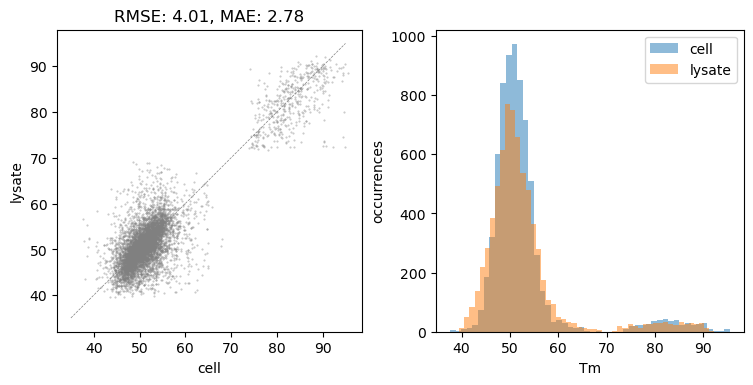

In [9]:
import matplotlib.pyplot as plt

########################################################################
# plot cell/lysate vs all
########################################################################
# left: scatter, right: histogram of differences

fig, ax = plt.subplots(
    1, 2,
    # sharex=True, sharey=True,
    figsize=(7.48, 3.74),
    layout='compressed',
)
ax = ax.flatten()

ax[0].scatter(
    meta_data[y1_grp][acc_loc[y1_grp],1].astype(np.float_),
    meta_data[y2_grp][acc_loc[y2_grp],1].astype(np.float_),
    c='gray',
    s=0.2,
    alpha=0.5,
    label='cell'
)
# ax[0].scatter(
#     meta_data[x_grp][acc_loc[x_grp],1].astype(np.float_),
#     meta_data[y2_grp][acc_loc[y2_grp],1].astype(np.float_),
#     c='C1',
#     s=0.3,
#     alpha=0.5,
#     label='lysate'
# )

ax[0].plot([35, 95], [35, 95], '--', c='gray', lw=0.5)

ax[0].set_xlabel(y1_grp)
ax[0].set_ylabel(y2_grp)
ax[0].set_title(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')
# ax[0].legend()
ax[0].set_aspect('equal')


# HISTOGRAM

ax[1].hist(
    (
        meta_data['cell'][acc_loc['cell'],1].astype(np.float_)
        # - meta_data['all'][acc_loc['all'],1].astype(np.float_)
    ),
    bins=50,
    color='C0',
    alpha=0.5,
    label='cell'
)
ax[1].hist(
    (
        meta_data['lysate'][acc_loc['lysate'],1].astype(np.float_)
        # - meta_data['all'][acc_loc['all'],1].astype(np.float_)
    ),
    bins=50,
    color='C1',
    alpha=0.5,
    label='lysate'
)

ax[1].set_xlabel('Tm')
ax[1].set_ylabel('occurrences')
ax[1].legend()

plt.savefig(f'cell vs lysates - {tag}.png', dpi=300)
plt.show()
plt.close()


In [10]:
# COUNT OCCURRENCES OF EXPERIMENTS

all_cell_acc = np.loadtxt(
    meta_file['cell'].replace('.csv', ' - all_entries (without_gene).csv'),
    delimiter=',',
    dtype=np.str_
)

all_lysate_acc = np.loadtxt(
    meta_file['lysate'].replace('.csv', ' - all_entries (without_gene).csv'),
    delimiter=',',
    dtype=np.str_
)

lines = []
for acc in meta_data['all'][:,0]:
    if acc in excluded_accessions:
        continue

    lines.append([
        acc,
        np.sum(all_cell_acc==acc),
        np.sum(all_lysate_acc==acc)
    ])

unique_rows, count = np.unique(
    np.array(lines)[:,1:], axis=0,
    return_counts=True
)
print(np.hstack((unique_rows, count[:,None])))

[['0' '1' '19135']
 ['1' '0' '2098']
 ['1' '1' '7139']]


In [11]:
np.savetxt(
    f'{deepstabp_col}/experiment_counts-counts.csv',
    np.hstack((unique_rows, count[:,None])),
    delimiter=',',
    fmt='%s',
    header='cell,lysate,occurrences',
)

np.savetxt(
    f'{deepstabp_col}/experiment_counts.csv',
    lines,
    delimiter=',',
    fmt='%s',
    header='accession,cell,lysate',
)